In [14]:
# Combined_Vehicle_Detection_Lane_Detection

## Project : Vehicle Detection 

**Goals :**
* Design a software pipeline to identify vehicles in a video from a front-facing camera on a car. 


1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 
   * Optionally, you can also apply a color transform and 
   * append binned color features, as well as 
   * histograms of color, to your HOG feature vectorand 
2. Train a classifier Linear SVM classifier

3. Normalize your features and randomize a selection for training and testing. for those first two steps
4.  Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5.  Run your pipeline on a video stream  
    * Create a heat map of recurring detections frame by frame to reject outliers and  follow detected vehicles.
    * Estimate a bounding box for vehicles detected.

### 1.  HOG features

After all test images was read using build_test_data(), we randomly choose an image.

We display this image using hog_parameters (orient = 9 ;  pix_per_cell = 8 ; cell_per_block = 2)

In [7]:
from myLib.vehicle_detector import *
%matplotlib inline

In [8]:
test_images='TestImages/*.jpeg'
cars, notcars, len_cars, len_notcars =  build_test_data (test_images)

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [10]:
# Define HOG parameters
orient = 9 ;  pix_per_cell = 8 ; cell_per_block = 2

In [11]:
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

/home/tiff/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


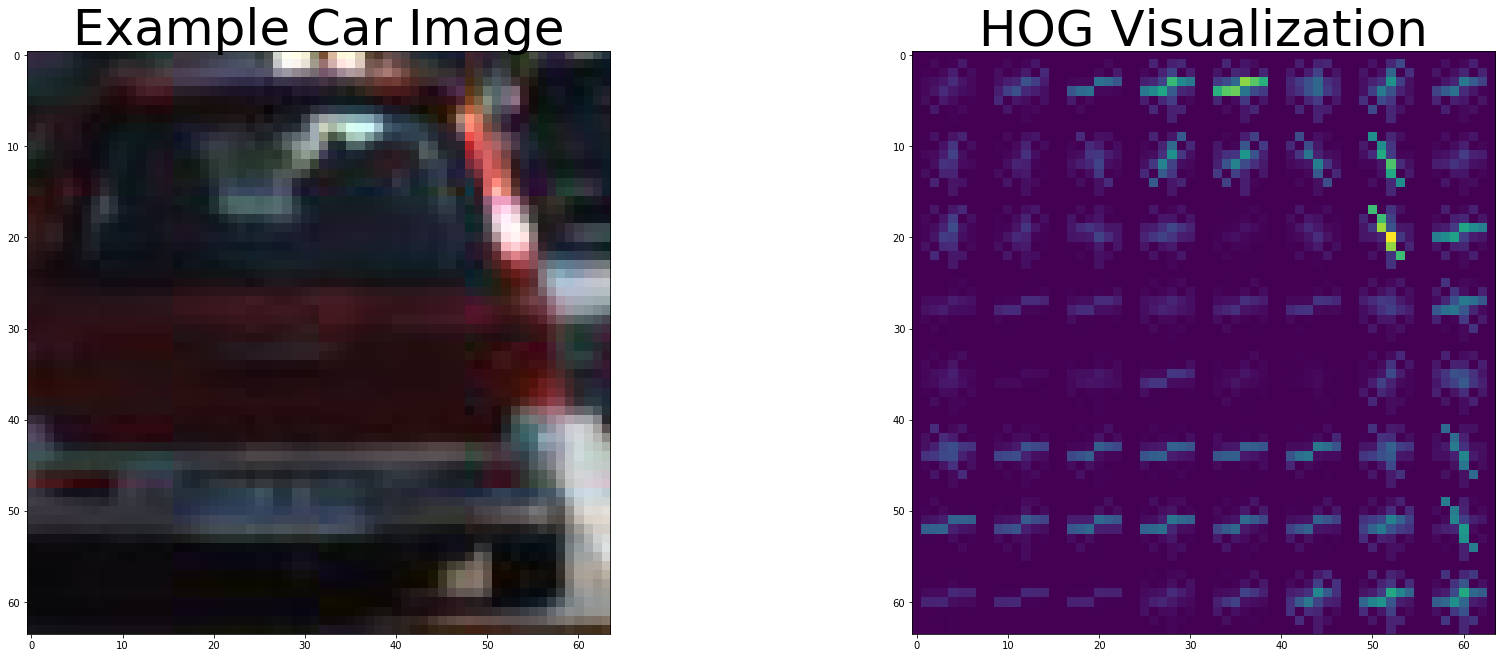

In [12]:
plot_2_images (image, hog_image, 'Example Car Image', 'HOG Visualization')

In [7]:
my_features = create_feature_parameters \
(color_space= 'HSV' , 
 spatial_size = (16, 16),
 hist_bins = 16,
 orient=9, pix_per_cell= 8, cell_per_block= 2, hog_channel = 'ALL',
spatial_feat = True,
hist_feat = True,
hog_feat = True)

### 2. Feature Extraction for Model

Like any printer, the larger density it can handle the better quality it can print.  
In order to distinguish objects in details easier, we need higher resolution.

All image features were used in helping neural network (LinearSVC) to detect car from image.

These features are (color_space, spatial_feat, hist_feat, hog_feat, orient, pix_per_cell, cell_per_block )

Using the large combinatorial feature values above to train the LinearSVC and then test with images to 

see which combinaion detect car correctly the most we arrive to final feature parameters.

Final feature paramenters are :
```
color_space    = 'RGB'

spatial_size   = (16,16)
hist_bins      = 16

orient         = 9
pix_per_cell   = 8
cell_per_block = 2
hog_channel    = 'ALL'

spatial_feat   = True
hist_feat      = True
hog_feat       = True
```

Increasing the orientation enhanced the accuarcy of the finally trained classifier, but increased the time required for computation.

The `color_space` was decided by training a classifier on different color spaces for spatial features, and `RGB` performed better than `HSV`, `HLS`, and `YCrCb` . 



### 3. Train-Test Split

The `train_test_split()` from `sklearn.model_selection` was used to randomized the data 
and make a 80-20% train-test split. 

The split was made so as to keep the ratio of vehicles and non-vehicles similar.  
The create_test_training_data () called `train_test_split()` 
and all also normalized features with StandardScaler().fit(X)

### 4. Model Training

1.  Model Training code can be find in **Vehicle_Dectection_NN_Training.**
2. First, training data is built using build_test_data() given it a directory for training image (TestImages)
3. Then, `LinearSVC` model of `sklearn` with default setting of `square-hinged` loss function.
The `l2` normalization is selected because it is fast and easy to use.
4. The trained model had accuracy of `98.7%` on test dataset. 
5. The trained model along with the parameters used for training were written to a `pickle` file to be further used by vehicle detection pipeline.

## 5. Vehicle Detection Pipeline
---

### 1. Sliding Window Search
For each frame of video stream, the `find_other_cars` in `./myLib/featureExtraction.py`,  
extract image features discussed above from image frame. 

With (ystart, ystop, scale) we make education guess that the front view of driver is the region 
which we more likely to see other vehicles.
We then divide this region into blocks and extract their features.  
With each block feature we use svc.predict() to see this block is a car or not.
If it is predicted a car, we draw a box around it and add this box to a other_vehicle list.
And in addition, we add the region which covers by the box to the heat map.
When there are more  boxes/vehicles detect in the same region, this region got hot on the heat map every quick.

Nothing is perfect, therefore there are times that we predict wrongly (false positive) 
and the the heat map will get hot at regions that are not correct.  
To reduce this effect, we clear the hot area that is under threshold once in a while (every 5 frame).

To enhance the ability to detect other car better, we deploy  multi-scale window search. 
And when we are moving from frame to frame, we accumulate the information for 20 consecutive frames then reset it. 

Code with multi-scale window search and heatmap to reduce false positives have been implemented in 
the class `VehicleDetector` in `./myLib/vehicle_detector.py` and is discussed in upcoming sections.

In [15]:
model_file     = 'modelRGB.pk'  
dist_pickle    = pickle.load( open(model_file, "rb" ) )

In [18]:
ystart = 400
ystop  = 656
scale  = 1 #1.5
svc            = dist_pickle["svc"]
X_scaler       = dist_pickle["X_scaler"]
color_space    = dist_pickle["color_space"]
orient         = dist_pickle["orient"]
pix_per_cell   = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size   = dist_pickle["spatial_size"]
hist_bins      = dist_pickle["hist_bins"]
hog_channel    = dist_pickle["hog_channel"]

/home/tiff/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


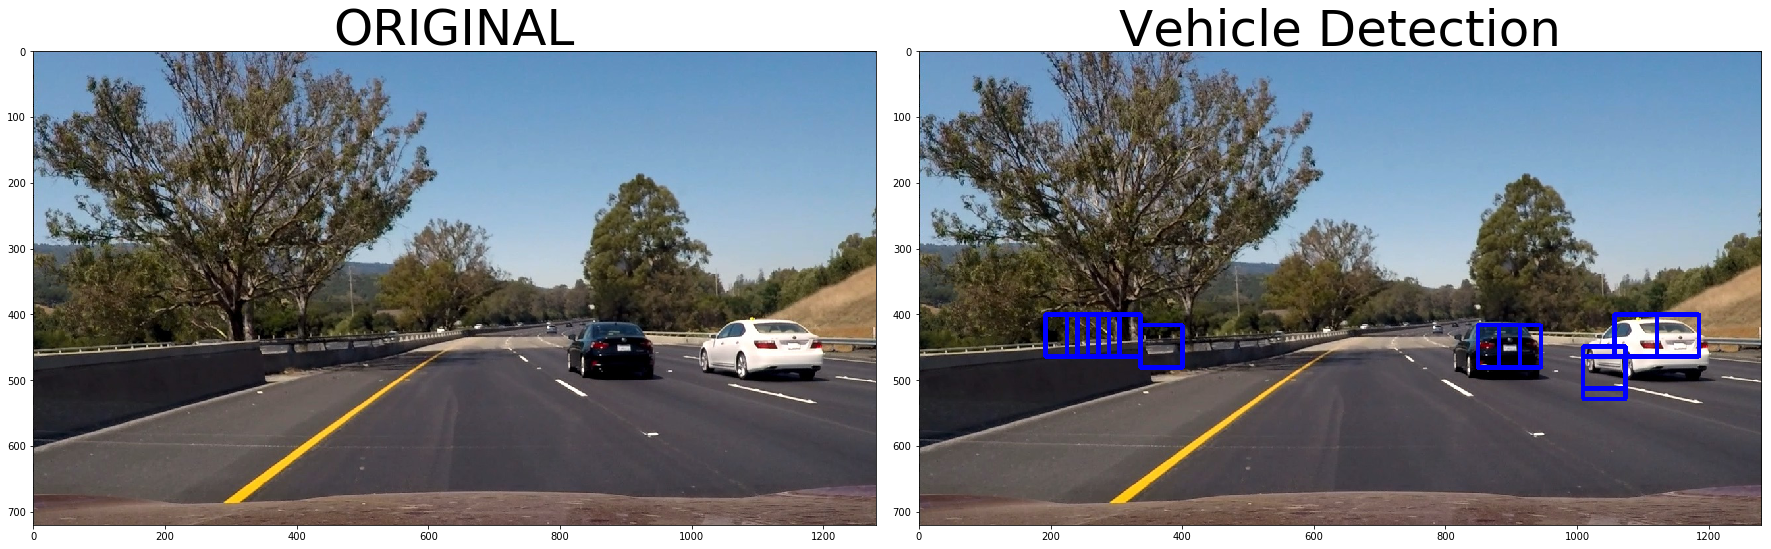

In [23]:
image = mpimg.imread('test_images/test6.jpg')
window_list= find_cars(image, \
            ystart, ystop, scale, \
            svc, X_scaler, \
            color_space, orient, pix_per_cell, cell_per_block,  spatial_size, hist_bins, hog_channel)
out_img = draw_boxes(image, window_list , color=(0, 0, 255), thick=6)
plot_2_images(image, out_img, "ORIGINAL", "Vehicle Detection")

### 2. Multi-Scale Search

The scale for the multi-window search and overlap inorder to look for other cars not on the sky or tree, and increase reliabilty in detection

The multi-scale window approach prevents calculation of feature vectors for the complete image and thus helps in speeding up the process. The following is decided:

1. Scale 1: (ystart,  ystop, scale) = (350, 600, 1.8) .
2.  Scale 2:(ystart,  ystop, scale) = (300, 600, 2.0) .
3.  Scale 3:(ystart,  ystop, scale) = (300, 700, 3.0) .


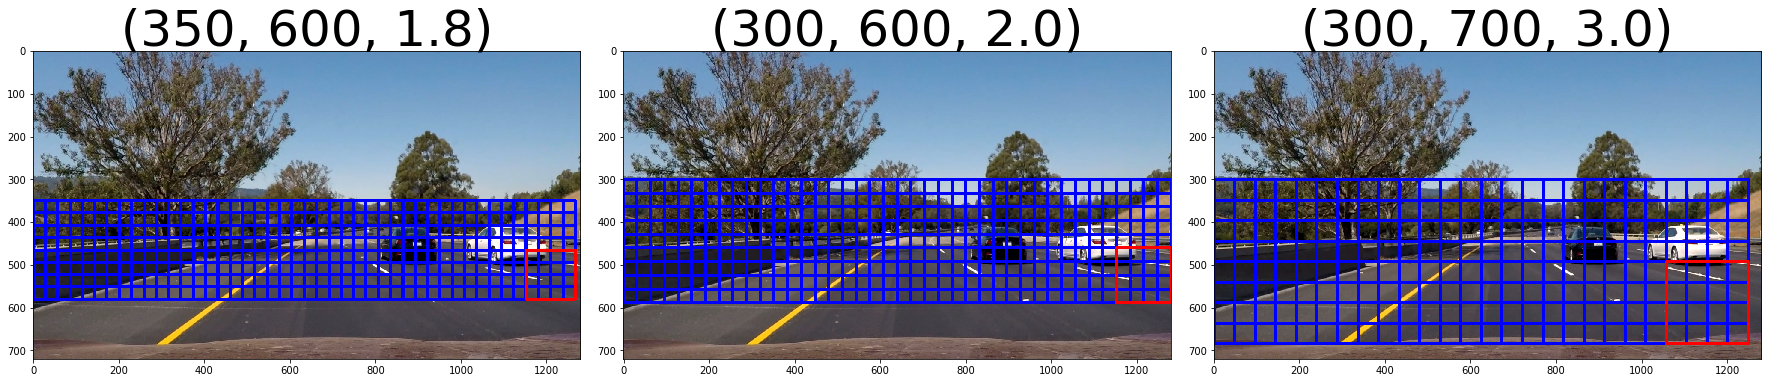

In [24]:
img = mpimg.imread('test_images/test6.jpg')
window_scale_list3 = [(350, 600, 1.8), (300, 600, 2.0), (300, 700, 3.0)]
i = 1
pix_per_cell = 8
imageList = []
for (ystart, ystop, scale) in window_scale_list3:
    image = draw_multi_scale_windows(img, ystart, ystop, scale, pix_per_cell)
    imageList.append(image)
    i+=1
plot_3_images(imageList[0], imageList[1], imageList[2], "(350, 600, 1.8)", "(300, 600, 2.0)", "(300, 700, 3.0)")

### 3. Avoiding False Positives and Label Detection

The false positives were avoided by using heat mapping technique.  
In this technique, marker was made in the scan area where svc linear trained model think there is a car.  
If this area is marked many times, it becomes a hotpot. 
`scipy.ndimage.measurements.label()` is used to identify individual blobs in the scan image 
and assumed there is a car in that area.

"Sliding window Search" above include explaination how to avoid false positive.


/home/tiff/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


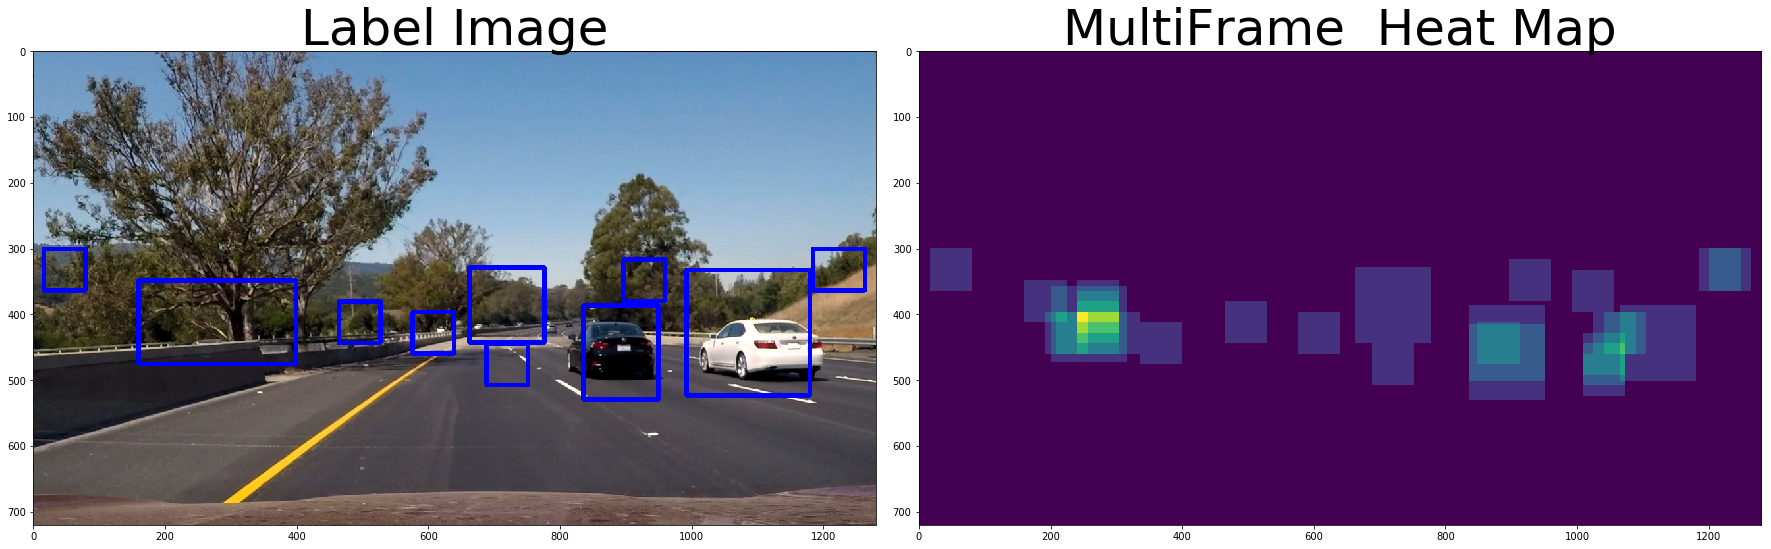

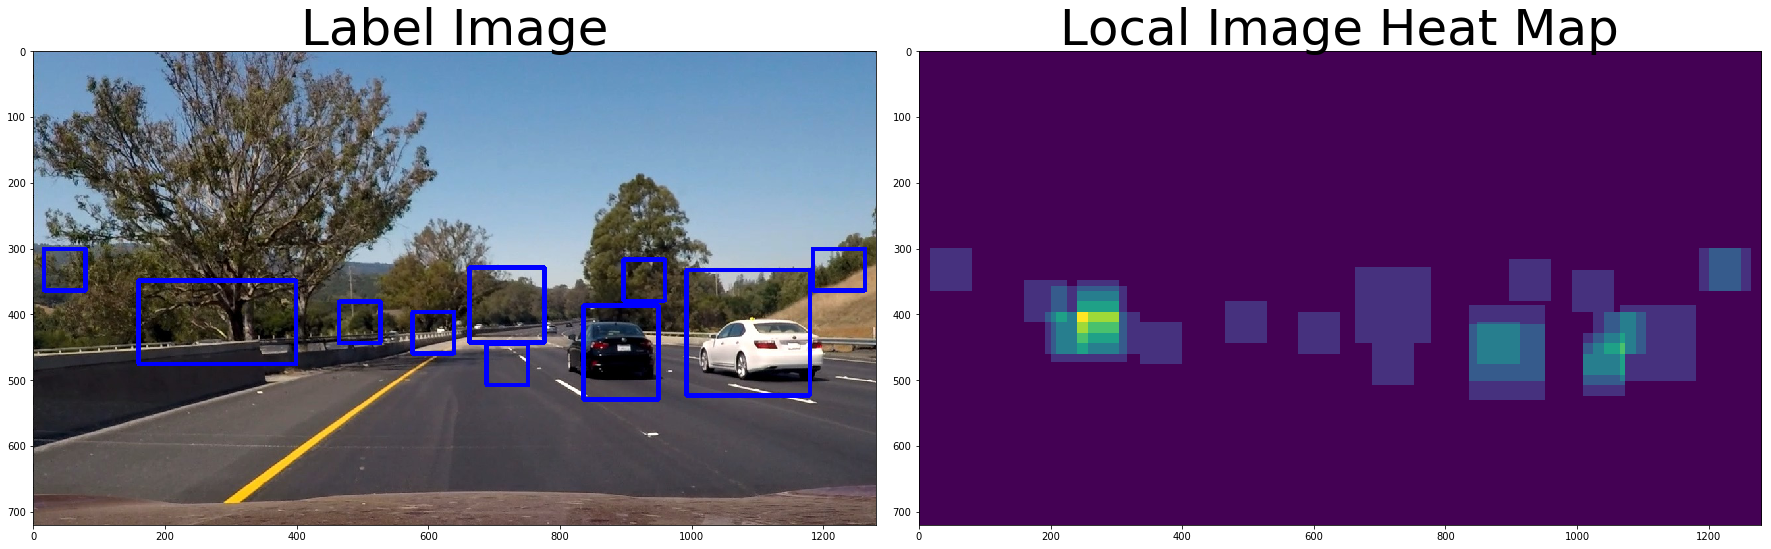

In [26]:
img = mpimg.imread('test_images/test6.jpg')
detector = VehicleDetector ('modelRGB.pk') 
detector.ystart_ystop_scale = [ (300, 600, 1.8),  (300, 600, 1.0)]
#detector.threshold = 3
out = detector.find_other_cars(img)
plot_2_images (out, detector.all_heatmap,"Label Image", "MultiFrame  Heat Map")
plot_2_images (out, detector.heatmap    ,"Label Image", "Local Image Heat Map")

### 4. Optimization Implementation in Searching Car 

Optimization was mplementated in  `find_other_cars`of `VehicleDetector` in `./myLib/vehicle_detector.py`.

Scanning to detect other cars was used on certain screen areas that more likely have car such as the front of driver view
is used instead of canning every where in the image.  
This reduced 50% of searching time.
To increase rate of detection and to reduce processing time /decision making time, scan interval (5) is used to 
apply threshold to heat map every other 5 frames.
The heat_scan_interval (20) is reset every other 20 frames is used for feed back mechanism for "Avoiding False Positives"


##  Vehicle Detection Video Implementation
---


In [28]:
model_file   = 'modelRGB.pk'
video_output = 'project_video _output.mp4'
video_input  = "project_video.mp4"
scan_area    = scale      = [ (300, 600, 1.8),  (300, 600, 1.0)] 
detector     = VehicleDetector(model_file)
detector.ystart_ystop_scale = scan_area

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip = VideoFileClip(video_input)
drive_clip = clip.fl_image(detector.find_other_cars)
%time drive_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [08:52<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 6min 26s, sys: 4.54 s, total: 6min 30s
Wall time: 8min 59s


In [29]:
model_file   = 'modelRGB.pk'
video_output = 'challenge_video_output.mp4'
video_input  = "challenge_video.mp4"
scan_area    = scale      = [ (300, 600, 1.8),  (300, 600, 1.0)] # best
detector = VehicleDetector(model_file)
detector.ystart_ystop_scale = scan_area

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#clip = VideoFileClip(video_input).subclip(t_start=30,t_end=135)
clip       = VideoFileClip(video_input)
drive_clip = clip.fl_image(detector.find_other_cars)
%time drive_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### 5. Discussion: 

Detection Other Vehicles pipeline  is a very difficult task.  
At the beginning, setting up this pipeline is long and lonely and hard.  
The need to have the data for training ready, normalize data, shuffle them, 
   chosing among many different neural network models, 
   different paramenters to experience for a particular model.  
And even when everything is ready, chosing scanning paramenters (ystart/ystop/scale) also affected 
   the performance of whether car is detected at all.  
Then it finally come to find "time"  to tune it to perform better than the last time (computing performance).
We run into lack of computing power. Things run to slow.
We run into automation issues where we wish we could pump a combinatorial set of parameters, run it and find out which one will give us best result.
The key to performance is to predict better, this means we need to train the model better,  this mean we need to have better data set.  This finally means we need to more time.